###  Use the gradient descent method to train a ReLU a shallow neural network for L^2 fitting tasks

Consider 1D  $L^2$-fitting problem on $\Omega = [0,1]$: 
		\begin{equation}
			\min_{f_n \in \Sigma_n} \int_{0}^1 \frac{1}{2} | f(x) - f_n(x) |^2dx.
		\end{equation}
        
 $\Sigma_n$  is the spcae of  ReLU shallow neural network with $n$ neurons 
	\begin{equation*}
		\Sigma_n = \left\{ v(x) = \sum_{i=1}^n a_i \sigma(x + b_i) : a_i \in \mathbb{R},  ~~ b_i \in \mathbb{R}\right\}, \quad \sigma(x) = \max(0,x).
	\end{equation*}
    
The resulting nonlinear, nonconvex optimization problem
			\begin{equation} \label{snn-optimization}
			 \min_{a_i, b_i} \int_{0}^{1} \frac{1}{2} |f(x) - \sum_{i=1}^{n} a_i \sigma( x + b_i) |^2 dx.  
		\end{equation}
	
The above optimization problem is usually solved by GD (or Adam). 

In [13]:
# Helper functions
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
from scipy.sparse import linalg
from pathlib import Path
torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi)
import matplotlib.pyplot as plt 

if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu"  
    
class model(nn.Module):
    def __init__(self, input_size, hidden_size1, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)

    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x)))
        return u1

def plot_l2_error_history(alg_name,hidden_size1,err): 
    plt.figure(dpi = 100)
    plt.title(alg_name + ': neuron number '+str(hidden_size1))
    plt.plot(err, label = 'L2 error', linewidth=1)
    plt.legend()
    plt.xlabel('epoch')
    plt.yscale('log')
    plt.ylabel('error')
    plt.show()

def plot_solution(r1,r2,model,x_test,u_true,name=None): 
    # Plot function: test results 
    u_model_cpu = model(x_test).cpu().detach()
    plt.figure(dpi = 100)
    plt.plot(x_test.cpu(),u_model_cpu,label = "nn function")
    plt.plot(x_test.cpu(),u_true.cpu(),label = "true")
    if name!=None: 
        plt.title(name)
    plt.legend()
    plt.show()
    
def PiecewiseGQ1D_weights_points(x_l,x_r,Nx, order):
    """ Output the coeffients and weights for piecewise Gauss Quadrature 
    Parameters
    ----------
    x_l : float 
    left endpoint of an interval 
    
    x_r: float
    right endpoint of an interval 
    
    integration_intervals: int
    number of subintervals for integration
    
    Returns
    -------
    coef1_expand
    
    gw_expand
    
    integration_points
    """
    x,w = np.polynomial.legendre.leggauss(order)
    gx = torch.tensor(x).to(device)
    gx = gx.view(1,-1) # row vector 
    gw = torch.tensor(w).to(device)    
    gw = gw.view(-1,1) # Column vector 
    nodes = torch.linspace(x_l,x_r,Nx+1).view(-1,1).to(device) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(Nx,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)

    return coef1_expand.to(device) * gw_expand.to(device), integration_points.to(device)


In [14]:
def AdamOrGD_train(my_model, target,learning_rate,num_epochs,Nx = 1024,order =5,initialize_=None): 
    """Training SNN using Adam or GD

    Parameters
    ----------
    my_model : nn model class 
        Shallow neural network model 
    target : function
        the target function
    learning_rate : float 
        learning rate for neural network training 
    num_epochs : int 
        number of epochs
    initialize_ : function
        initialize the nn parameters

    Returns
    -------
    err : torch tensor
        L2 error history with respect to the epoch number 
    my_model : nn model class 
        trained nn model
    """
    
    def loss_function_inside(x): # Integrand of the loss function
        return 0.5*torch.pow(my_model(x)-target(x),2).to(device)

    
    weights, integration_points = PiecewiseGQ1D_weights_points(x_l= 0,x_r= 1, Nx = Nx,order =order)

    start = time.time()
    hidden_size1 = my_model.fc1.bias.size(0)
    print("current hidden layer size: ",hidden_size1)
    if initialize_ != None: 
        initialize_(my_model,target)
        
    # Plot initial guess and compute initial error
    x_test = torch.linspace(0,1,512).view(512,1).to(device) 
    u_true = target(x_test)
    plot_solution(0,1,my_model,x_test,u_true)
    
    with torch.no_grad():
        loss = weights.t() @ loss_function_inside(integration_points)
    err = torch.zeros(num_epochs+1, 1)
    err[0] = (2*loss)**0.5
    print("original loss", err[0])
    # Define variables for data to be stored 

    
    # Define optimizer 
    optimizer = optim.Adam(my_model.parameters(), lr=learning_rate)
    
    # Start the training process
    lr = learning_rate  
    for epoch in range(num_epochs):
        # Plot the numerical solution 
        if (epoch+1) % 1000 == 0: 
            print("epoch: ",epoch+1)
            plot_solution(0,1,my_model,x_test,u_true)
          
        lr = learning_rate 
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr * (0.98 ** ((epoch + 1) // 1000)) # Learning rate schedule
        optimizer.zero_grad() # Clear gradient 
        
        # Define the loss function 
#         node = compute_integration_nodes_relunn(-pi,pi,my_model)
#         loss = GQ_piecewise(gw,gx,node,loss_function_inside)
        loss = weights.t() @ loss_function_inside(integration_points)
        loss.backward() # Compute gradient 
        optimizer.step() # Gradient descent step
        ## Add the backtracking
        with torch.no_grad(): 
            loss = weights.t() @ loss_function_inside(integration_points)
        err[epoch+1] = torch.pow(loss.detach()*2.0,0.5)

    # Plot L^2 error history and solution 
    plot_l2_error_history("Adam: ",hidden_size1,err)
    plot_solution(0,1,my_model,x_test,u_true)
    end = time.time()
    print(str(end - start)+" s")
    return err, my_model

### Experiments

1. $f(x) = sin(x)$

2. $f(x) = sin(x) + 0.2*sin(10*x)$

current hidden layer size:  20


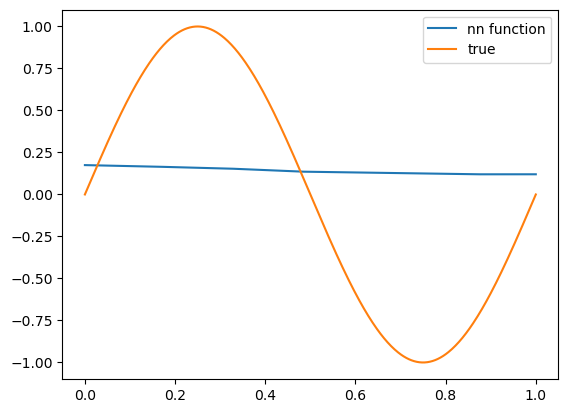

original loss tensor([0.7065])
epoch:  1000


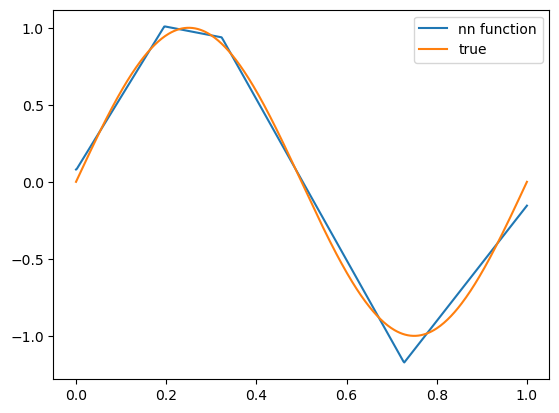

epoch:  2000


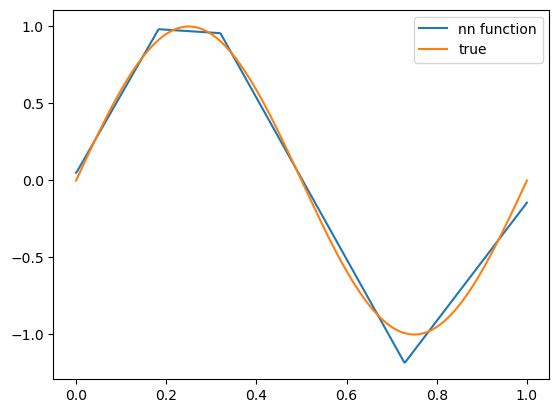

epoch:  3000


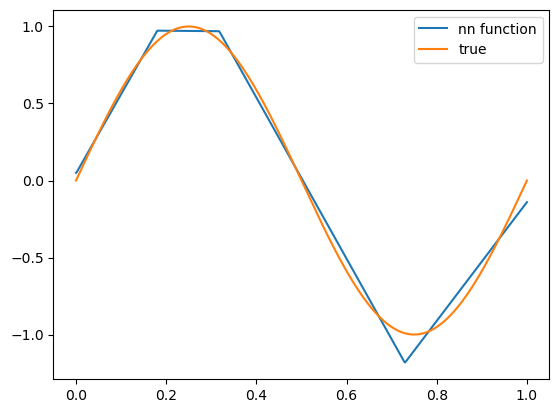

epoch:  4000


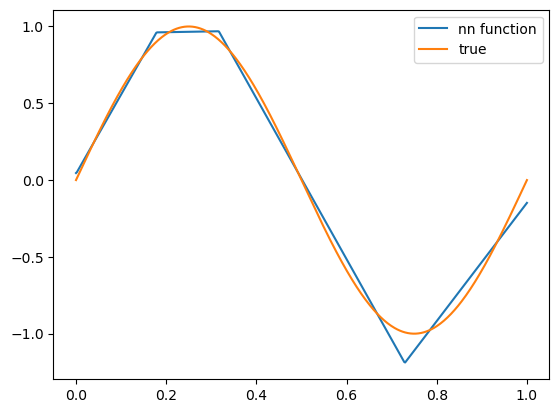

epoch:  5000


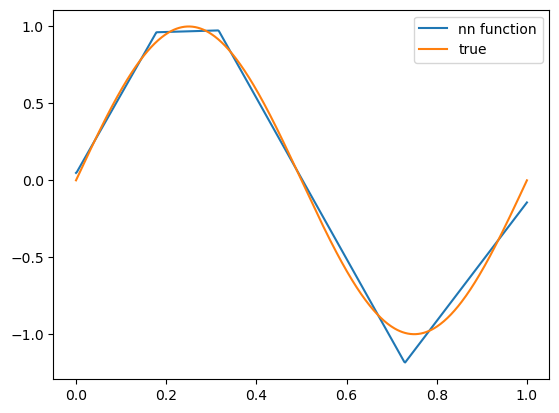

epoch:  6000


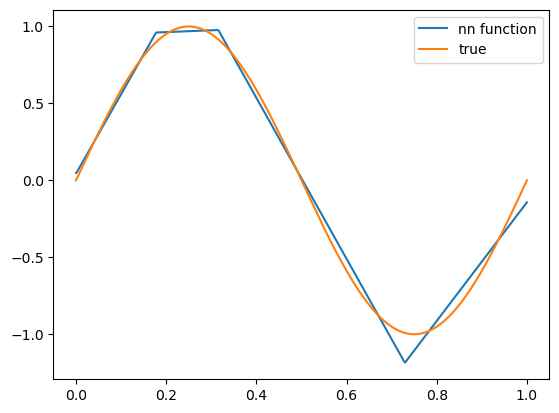

epoch:  7000


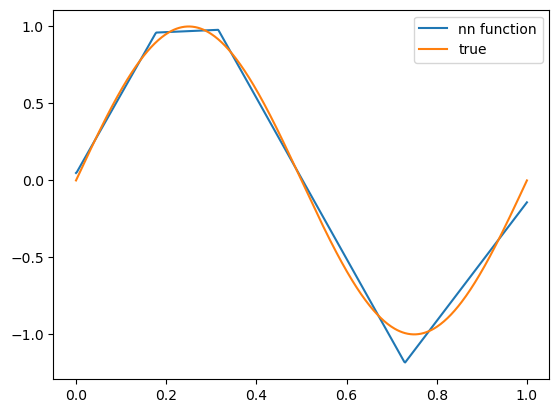

epoch:  8000


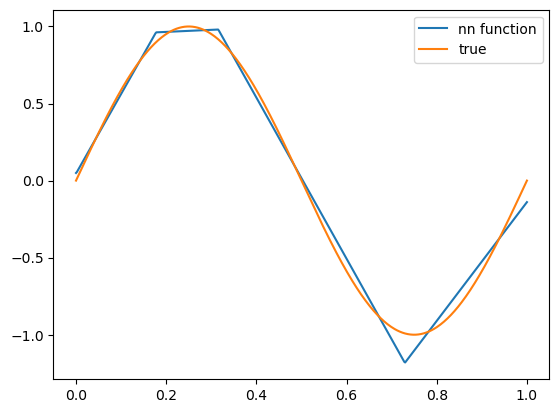

epoch:  9000


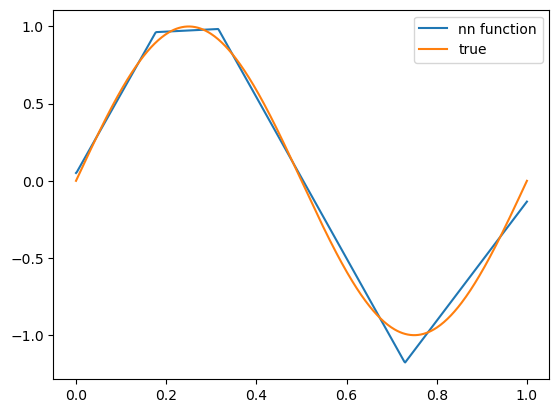

epoch:  10000


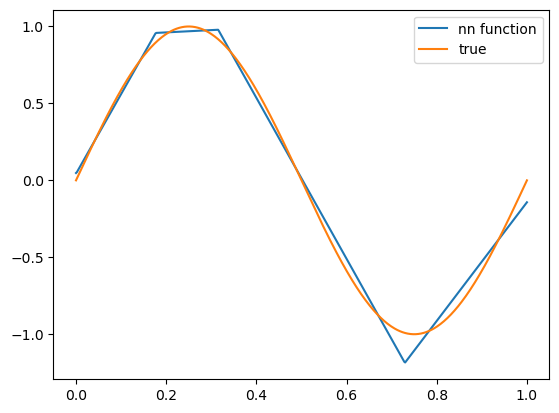

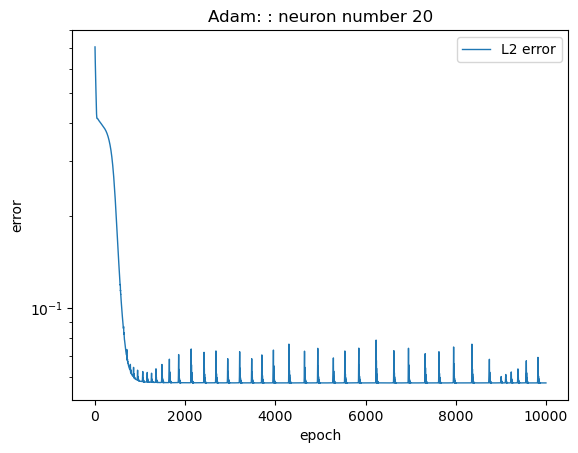

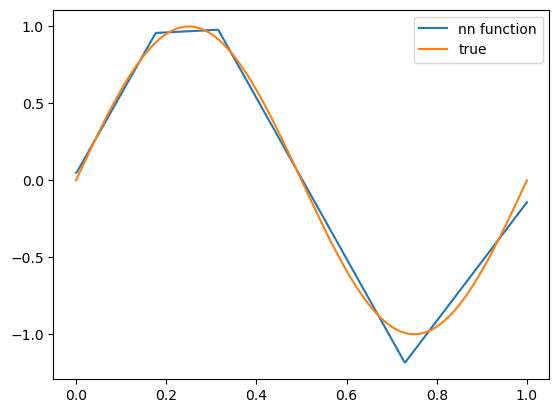

24.53123378753662 s


In [15]:
my_model = model(1,20,1)
def target(x):
    return torch.sin(2*pi*x)
learning_rate = 0.01
Nx = 512 
order = 2 
initialize_ = None 
num_epochs = 10000
err, my_model = AdamOrGD_train(my_model, target,learning_rate,num_epochs,Nx,order,initialize_)

current hidden layer size:  20


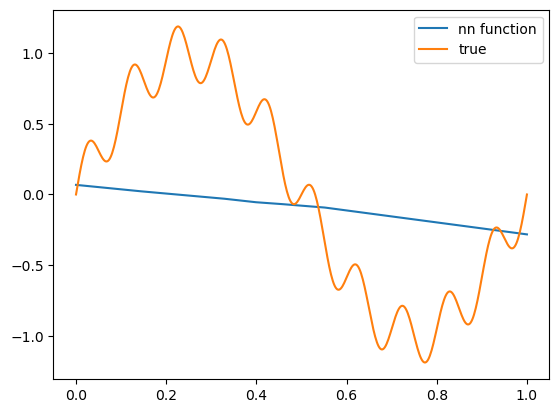

original loss tensor([0.6549])
epoch:  1000


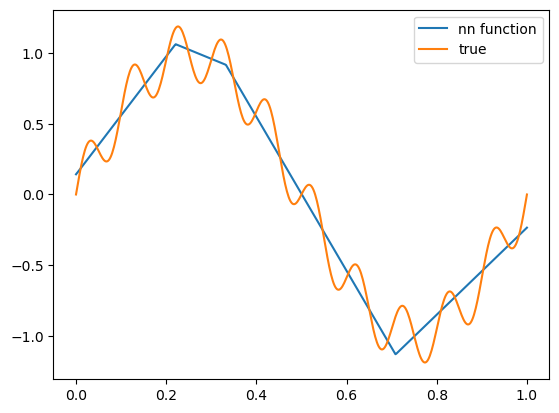

epoch:  2000


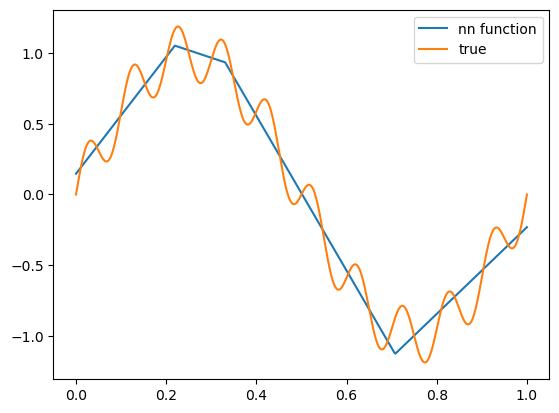

epoch:  3000


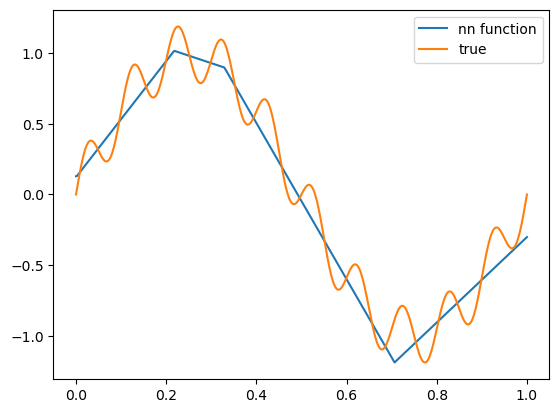

epoch:  4000


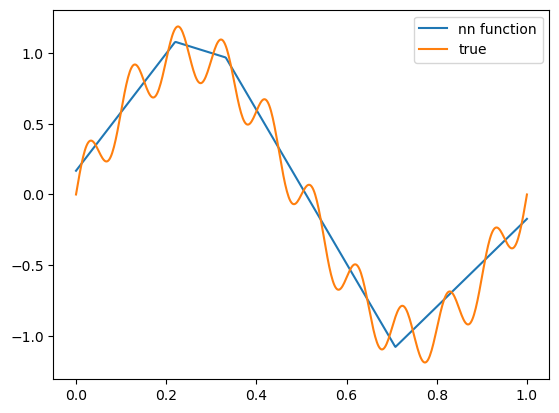

epoch:  5000


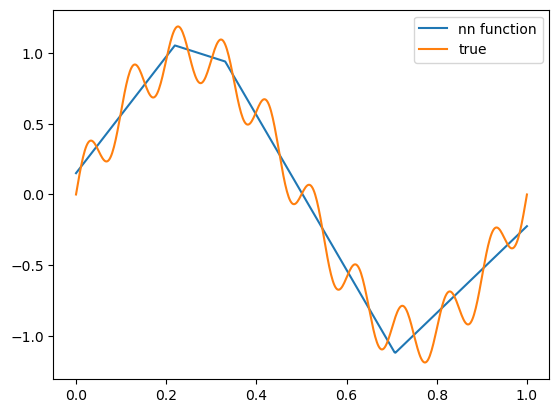

epoch:  6000


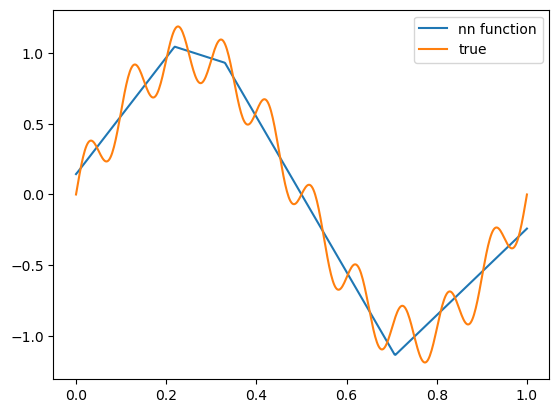

epoch:  7000


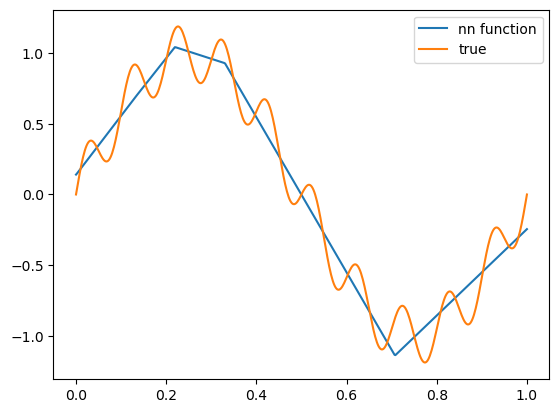

epoch:  8000


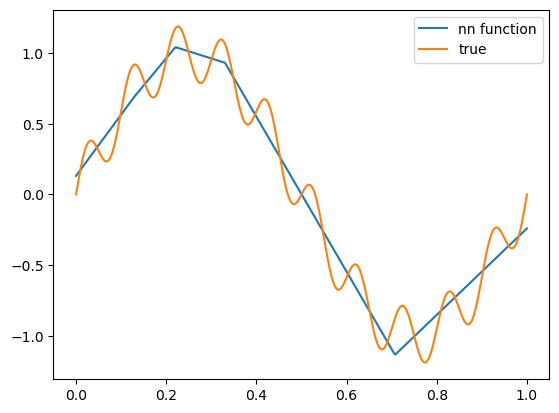

epoch:  9000


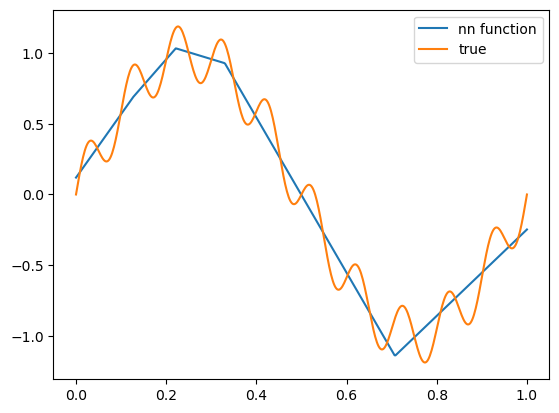

epoch:  10000


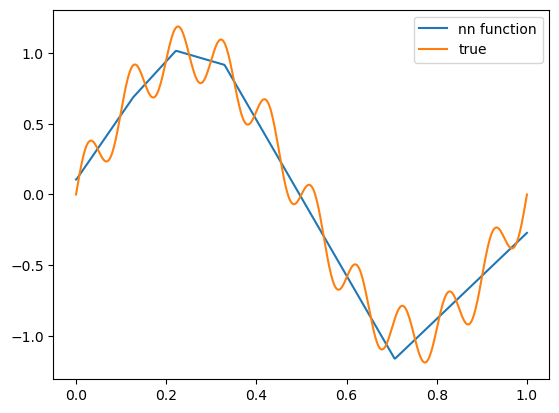

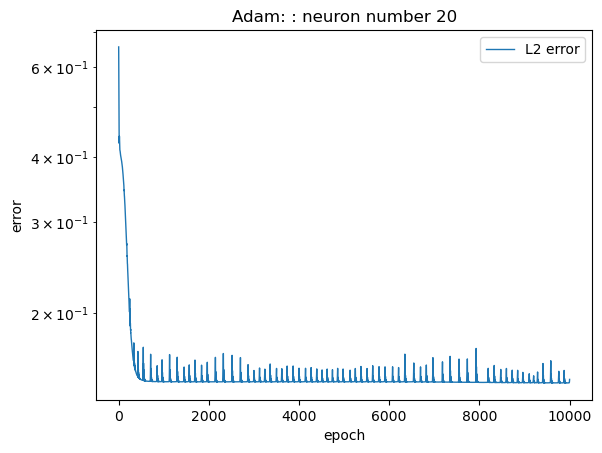

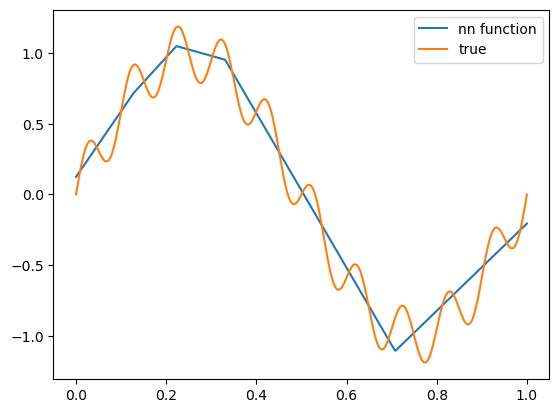

29.03875994682312 s


In [16]:
my_model = model(1,20,1)
def target(x):
    return torch.sin(2*pi*x) + 0.2*torch.sin(10*2*pi*x)
learning_rate = 0.02 
Nx = 1024 
order = 2 
initialize_ = None 
num_epochs = 10000
err, my_model = AdamOrGD_train(my_model, target,learning_rate,num_epochs,Nx,order,initialize_)

current hidden layer size:  8


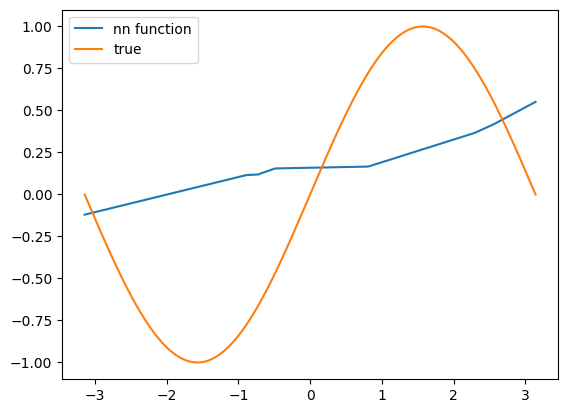

original loss tensor([[1.5938]])


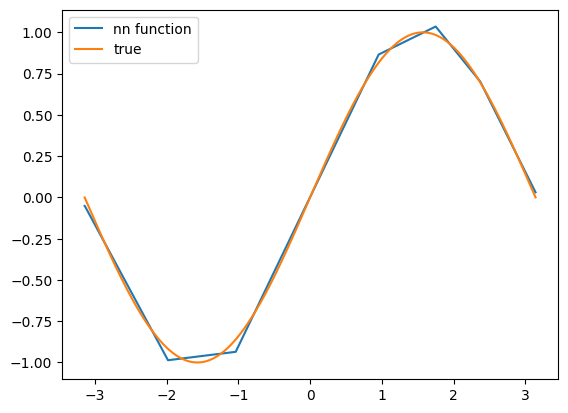

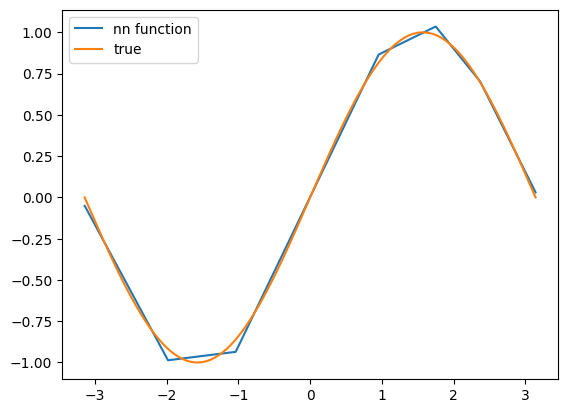

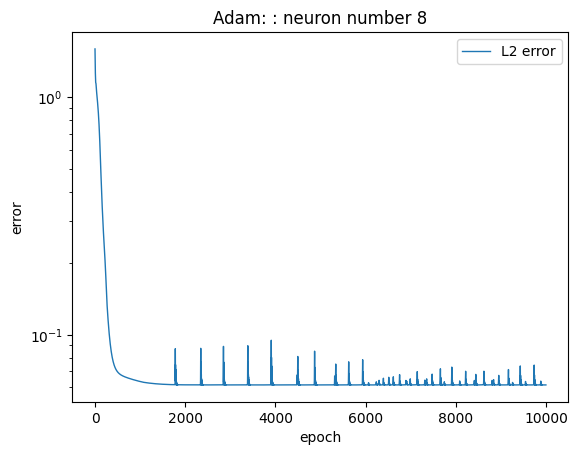

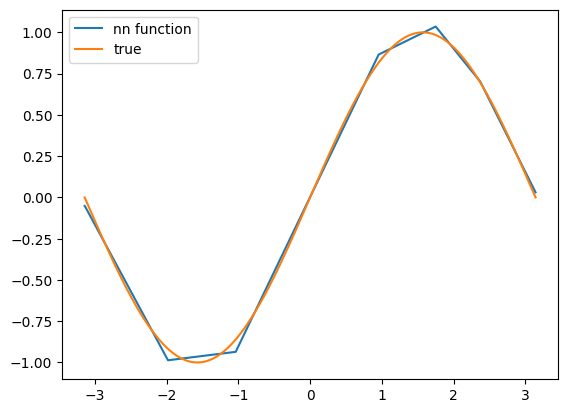

51.97726488113403 s
current hidden layer size:  16


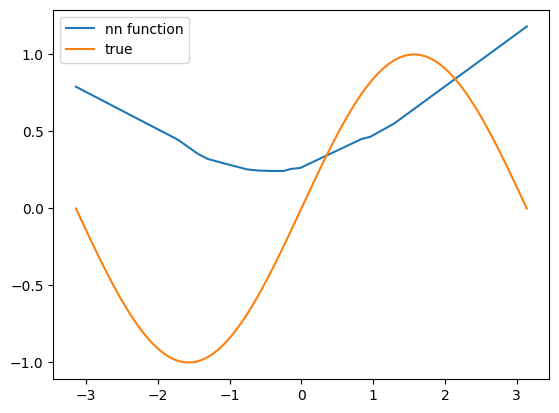

original loss tensor([[2.1333]])


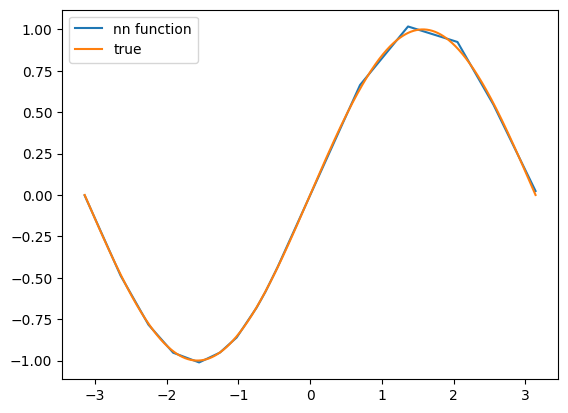

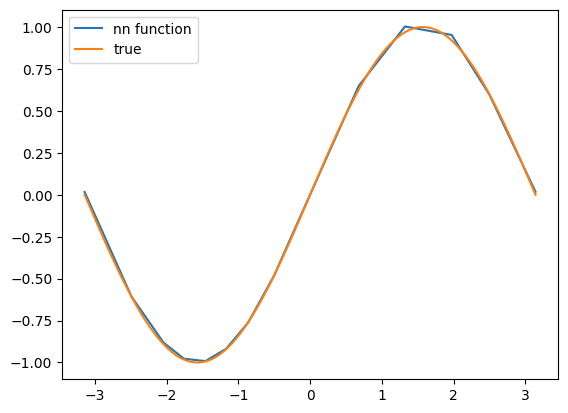

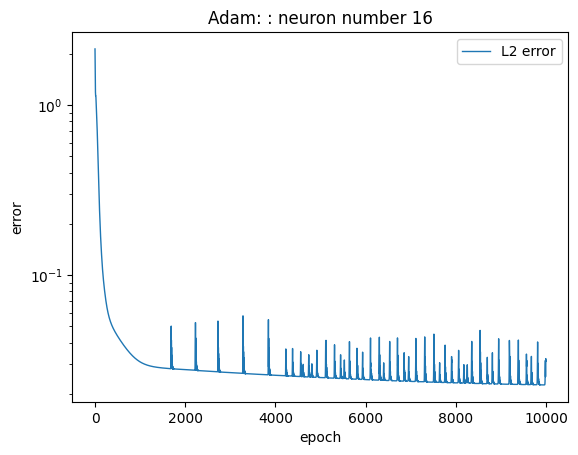

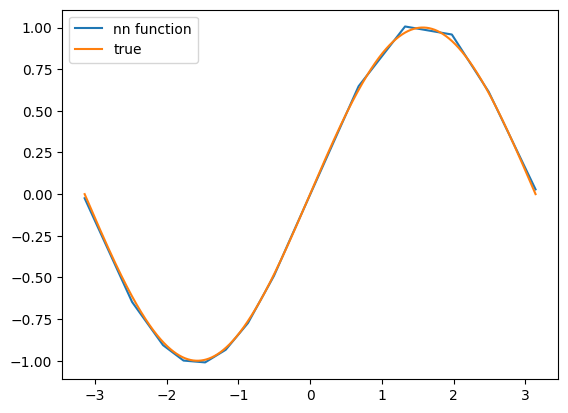

38.30244302749634 s
current hidden layer size:  32


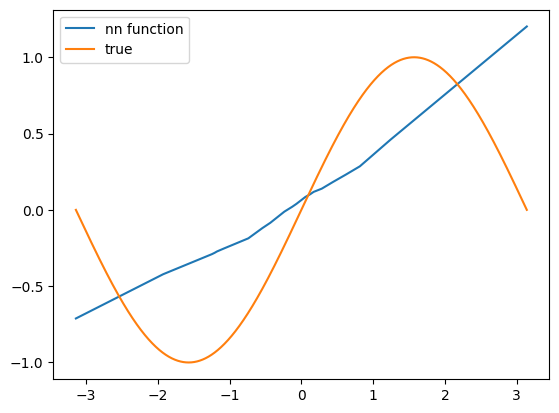

original loss tensor([[1.1715]])


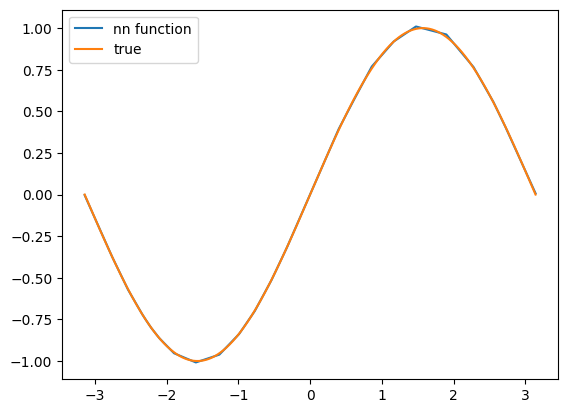

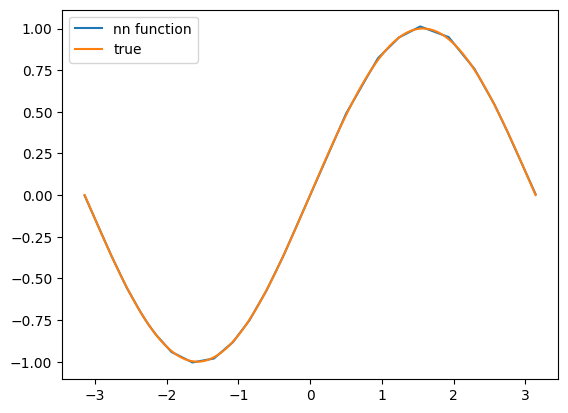

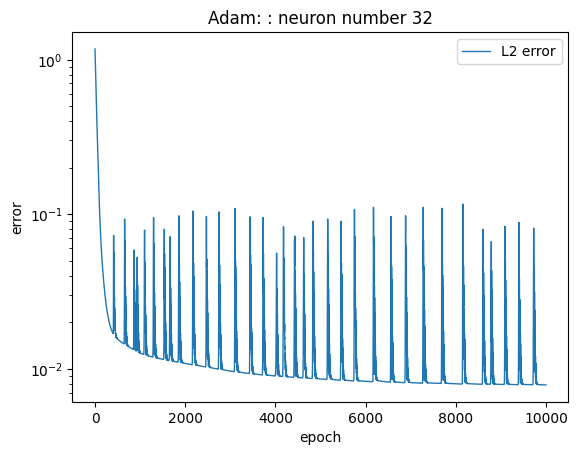

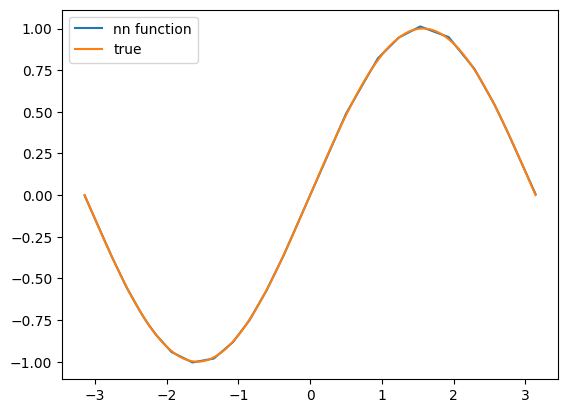

32.52397918701172 s
current hidden layer size:  64


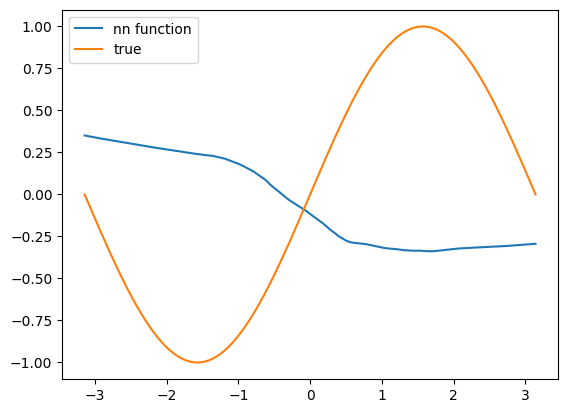

original loss tensor([[2.3936]])


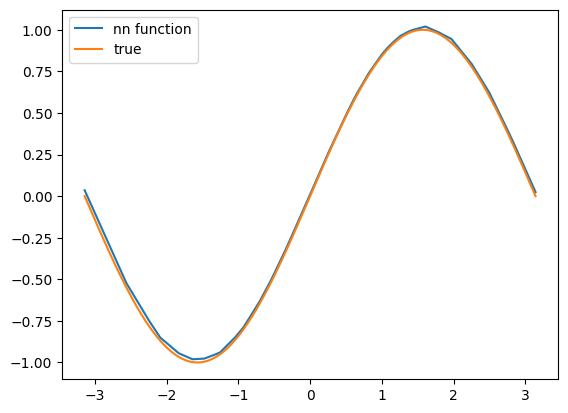

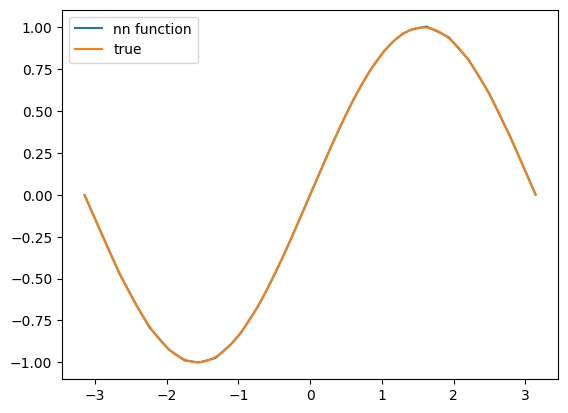

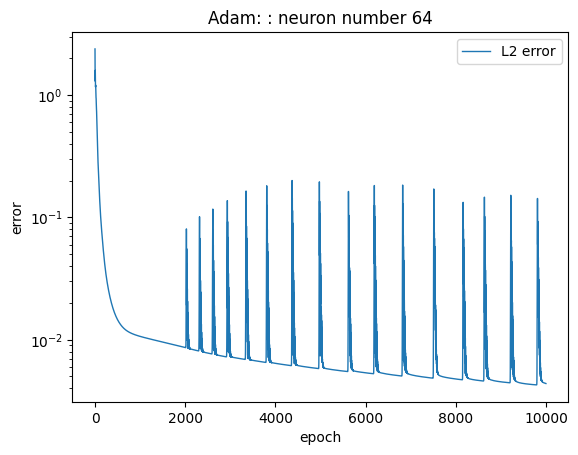

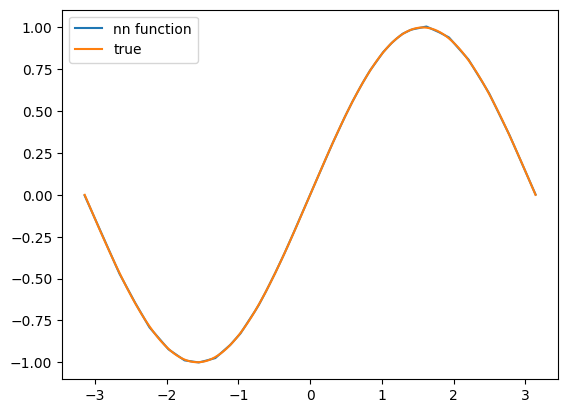

39.16763377189636 s
[tensor([0.0614]), tensor([0.0226]), tensor([0.0078]), tensor([0.0043])]


In [5]:
def target(x):
    return torch.sin(x) 
err_list = []
for neuron_num in [8,16,32,64]: 
    my_model = model(1,neuron_num,1)
    learning_rate = 0.01 
    initialize_ = None 
    num_epochs = 10000
    err, my_model = AdamOrGD_train(my_model, target,learning_rate,num_epochs,initialize_)
    err_list.append(min(err))
print(err_list)

current hidden layer size:  8


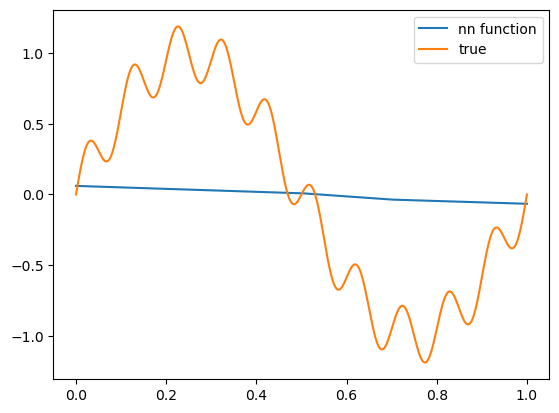

original loss tensor([0.6888])


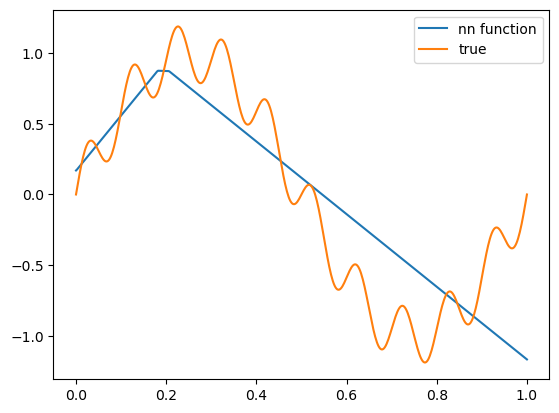

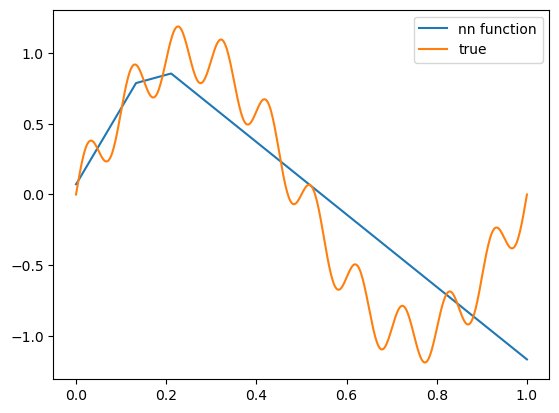

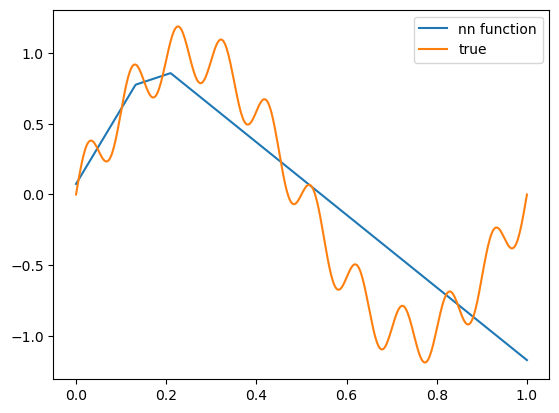

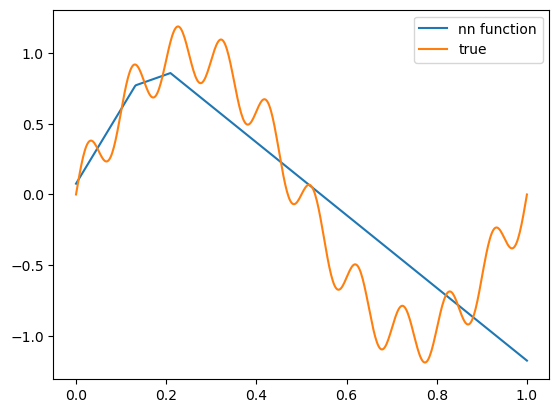

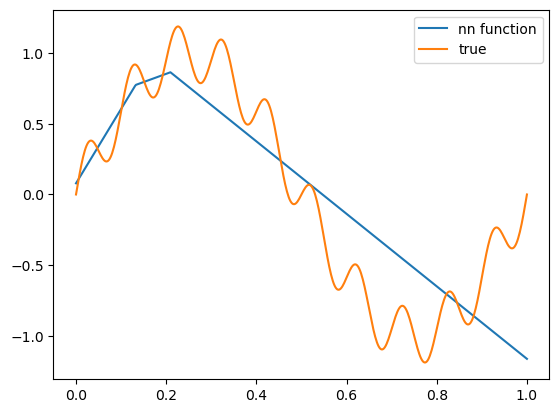

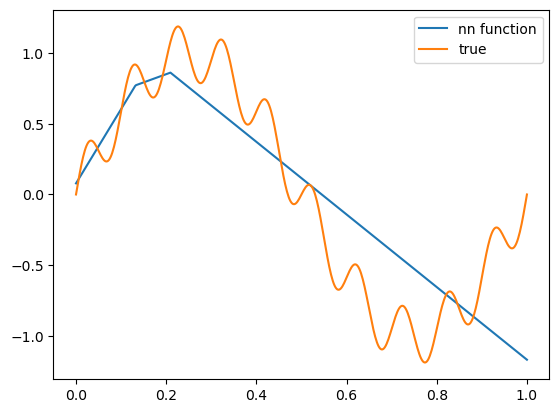

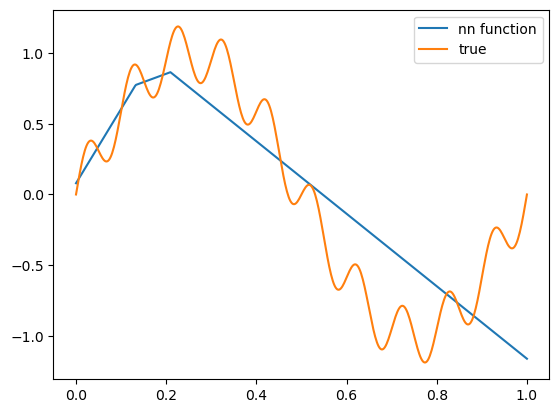

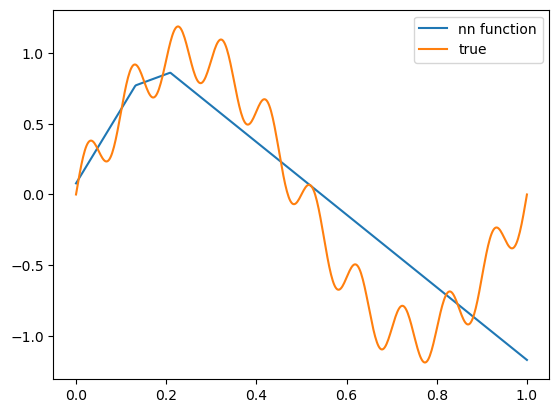

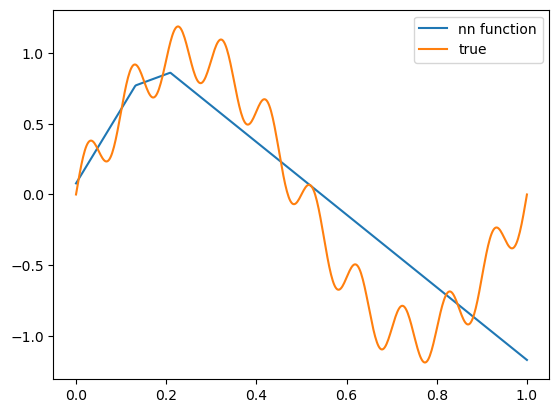

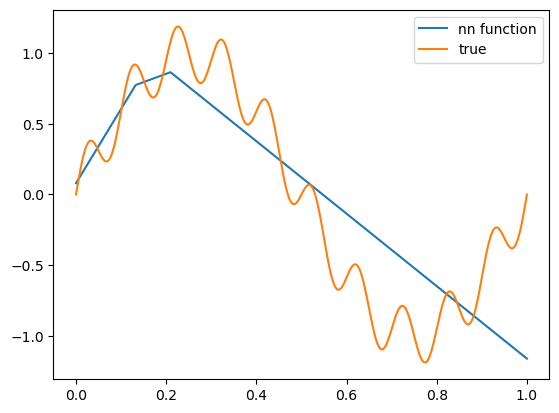

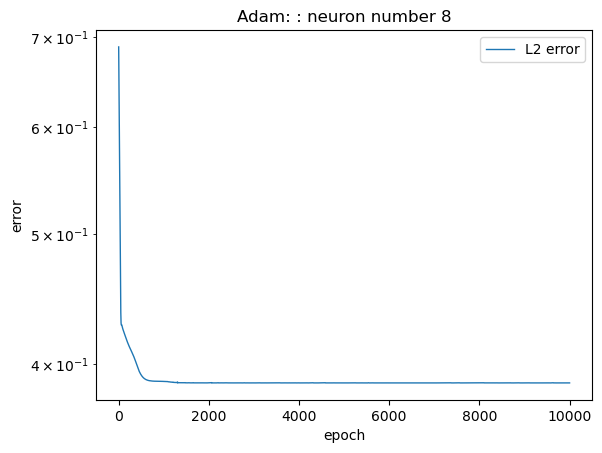

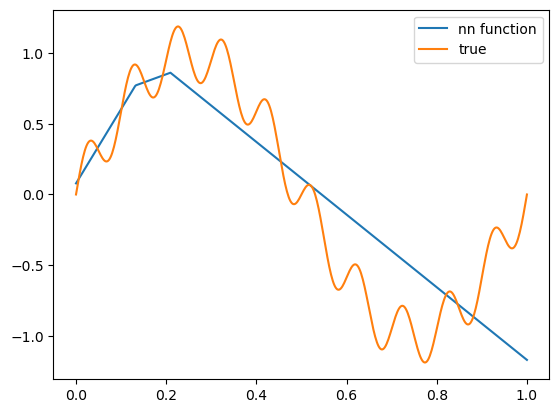

23.35480308532715 s
current hidden layer size:  16


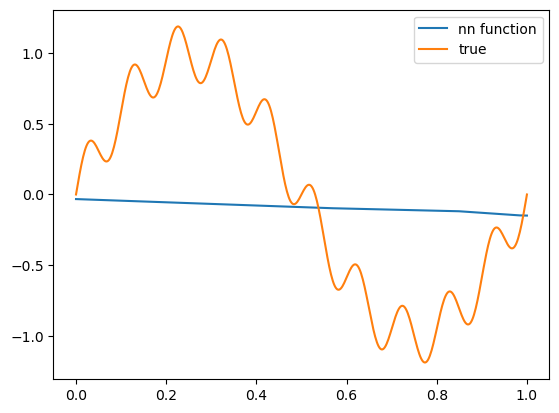

original loss tensor([0.7039])


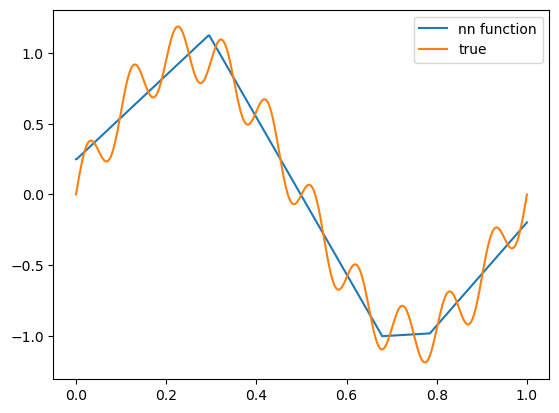

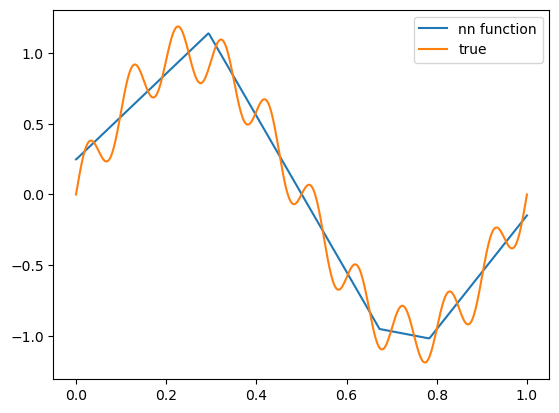

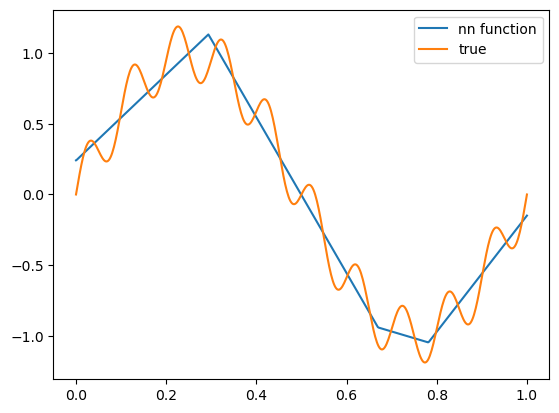

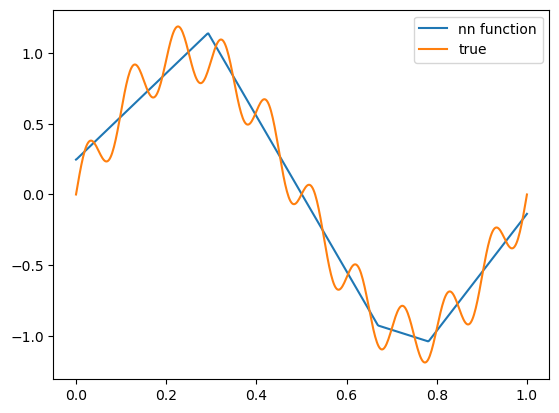

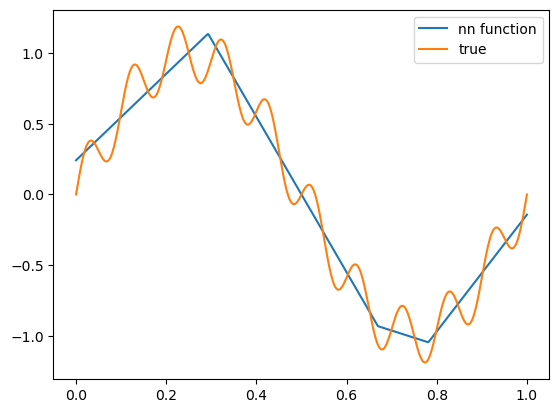

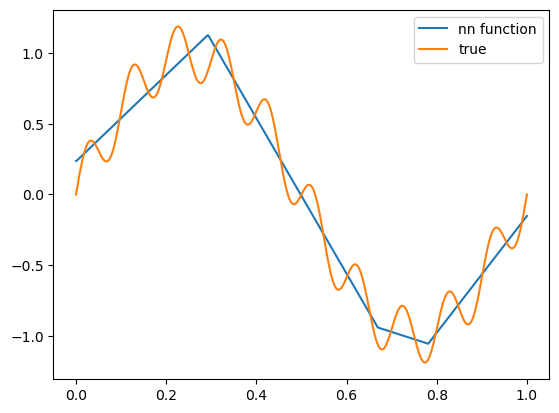

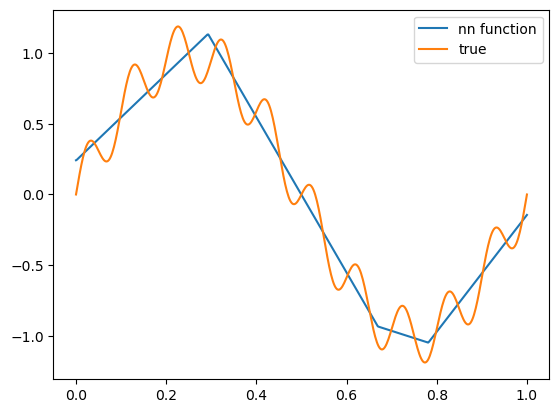

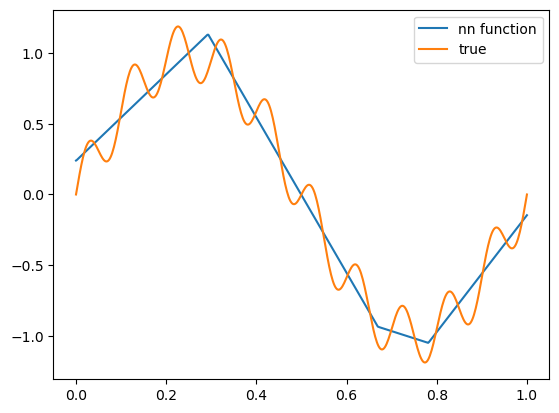

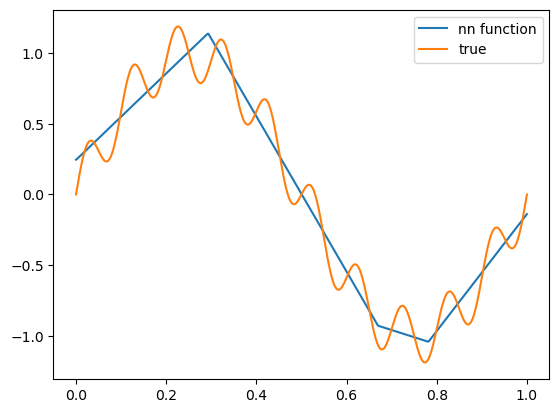

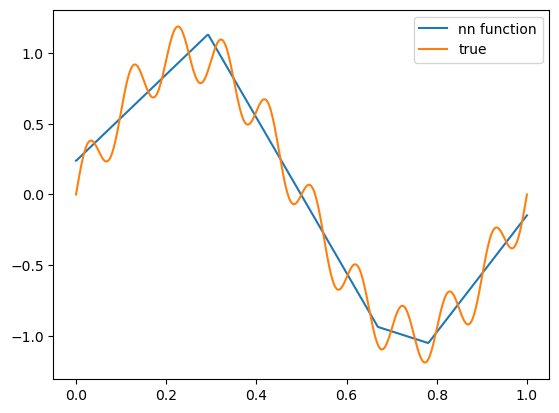

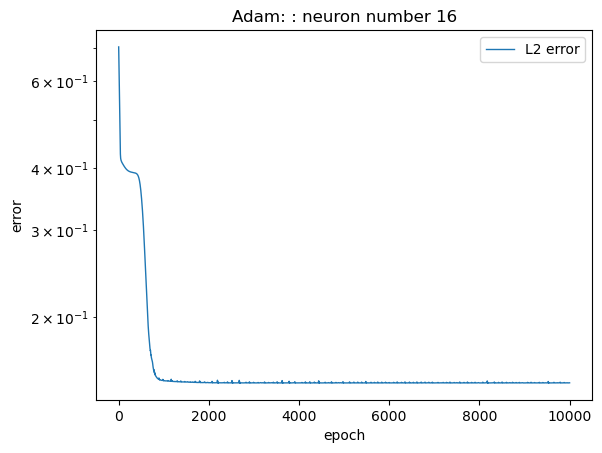

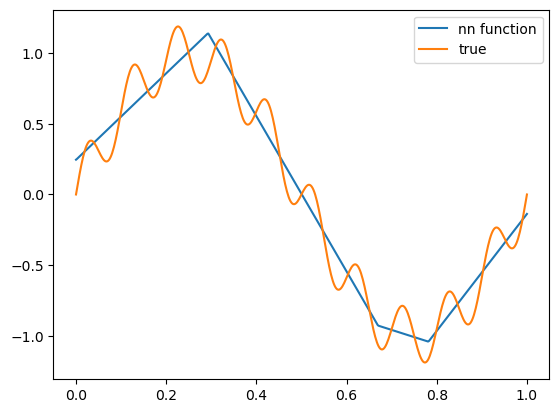

24.841623783111572 s
current hidden layer size:  32


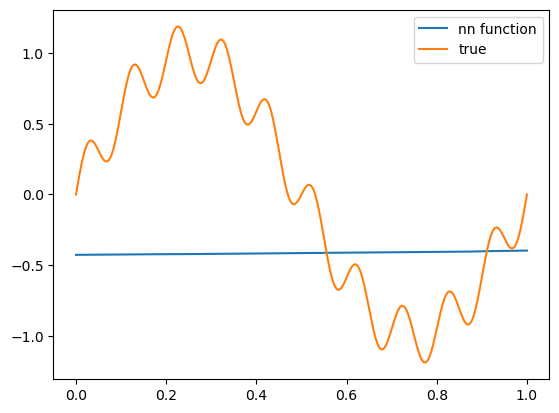

original loss tensor([0.8369])


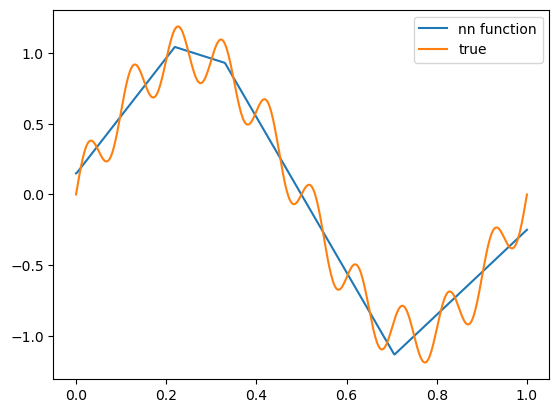

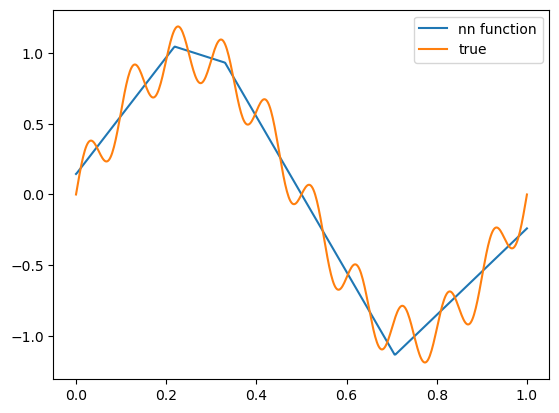

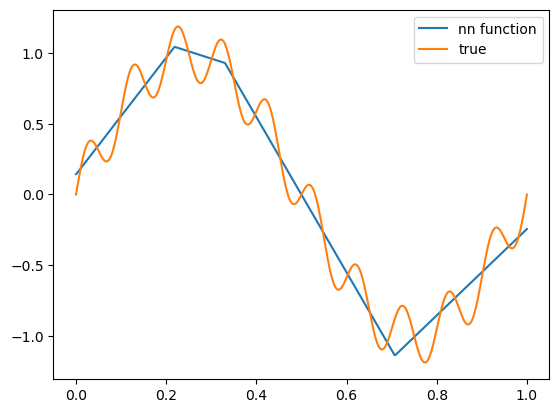

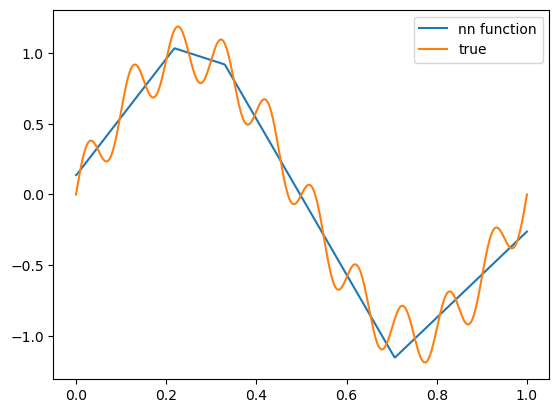

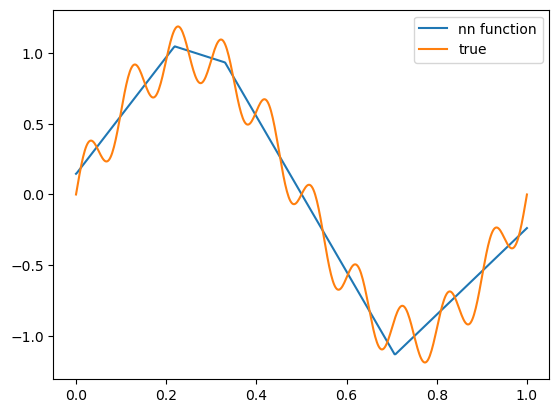

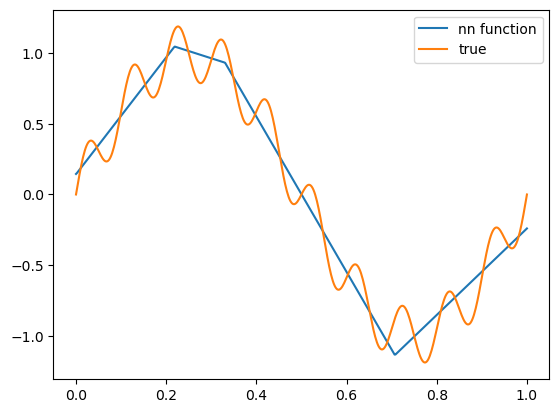

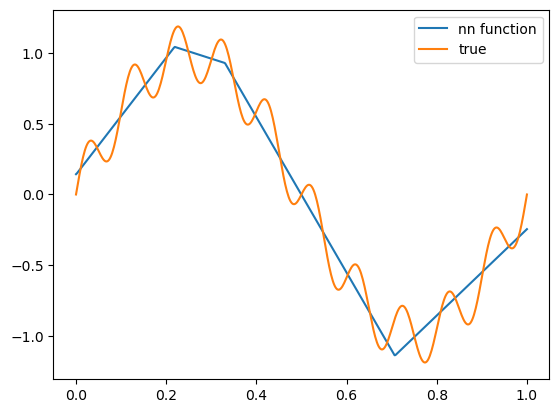

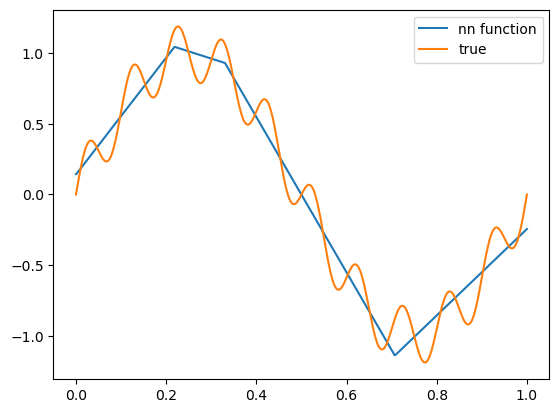

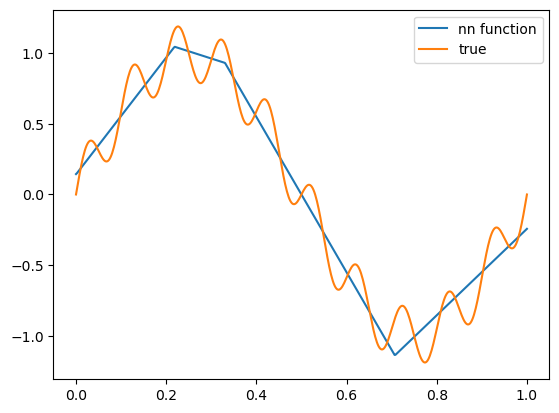

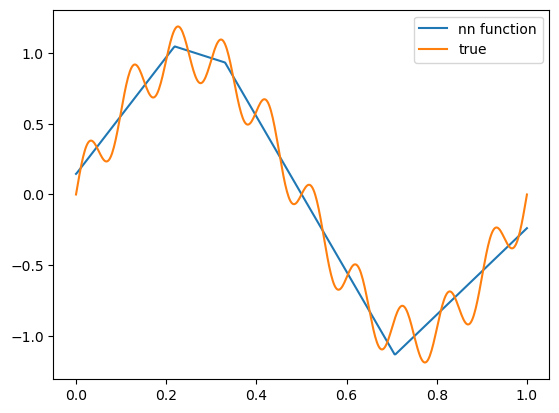

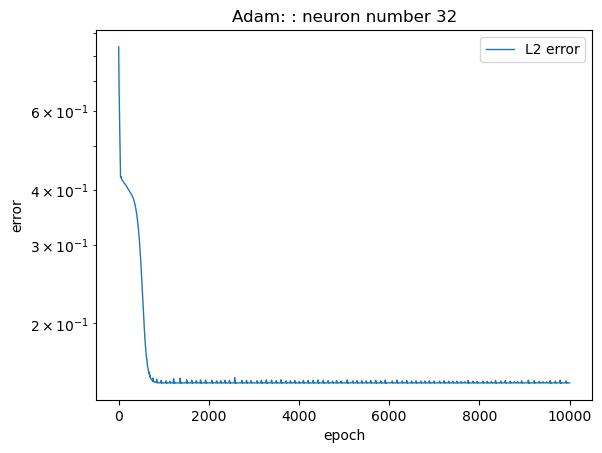

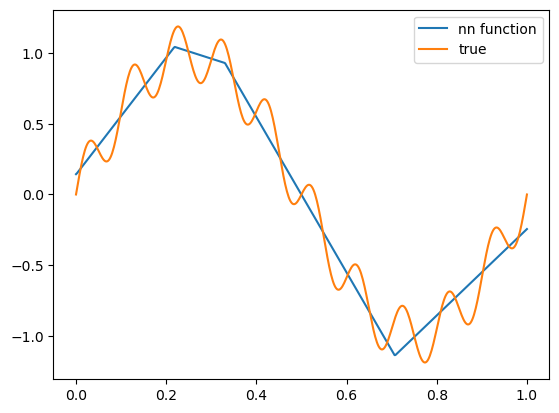

26.510521173477173 s
current hidden layer size:  64


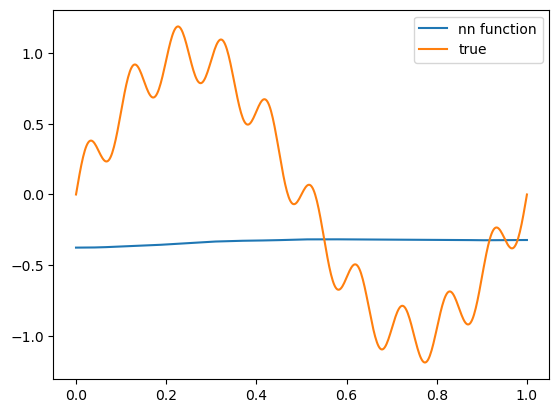

original loss tensor([0.8048])


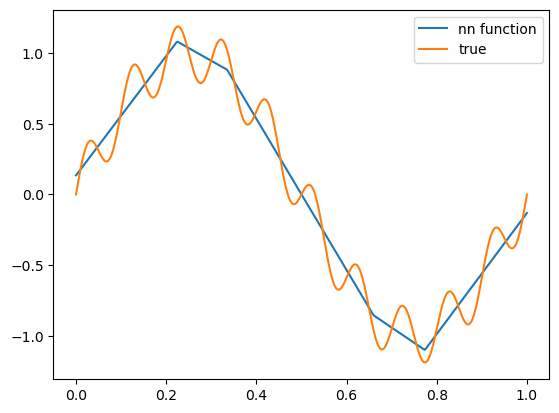

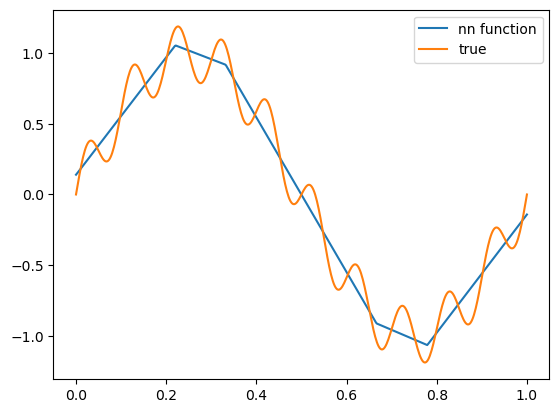

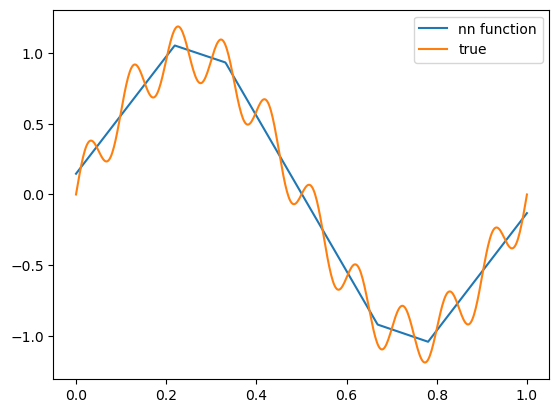

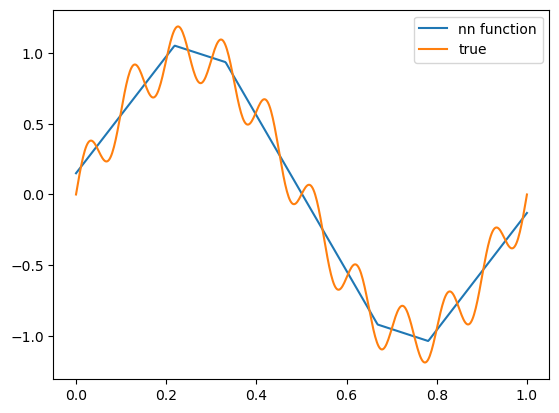

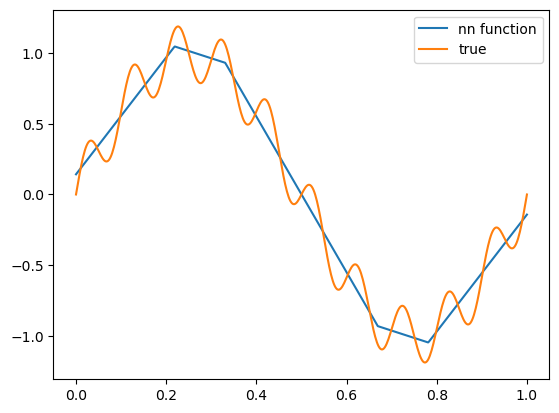

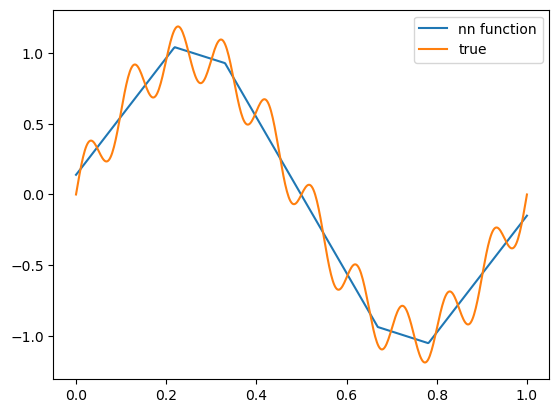

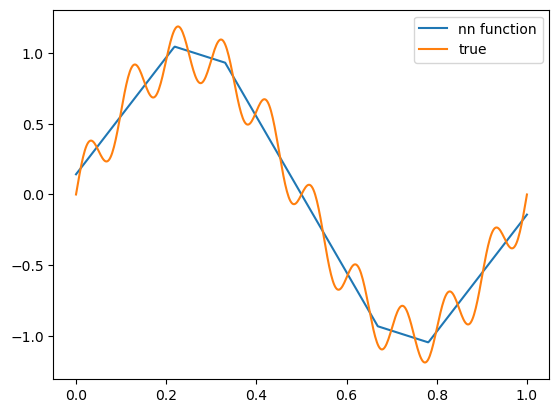

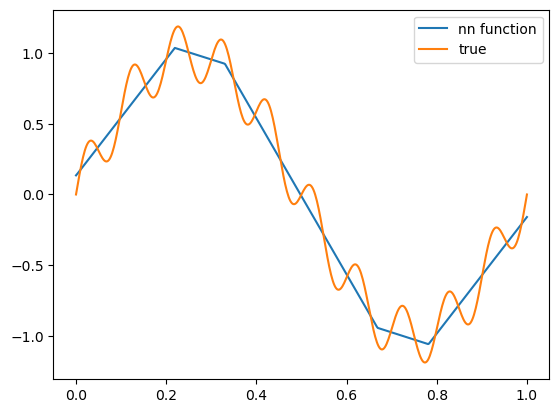

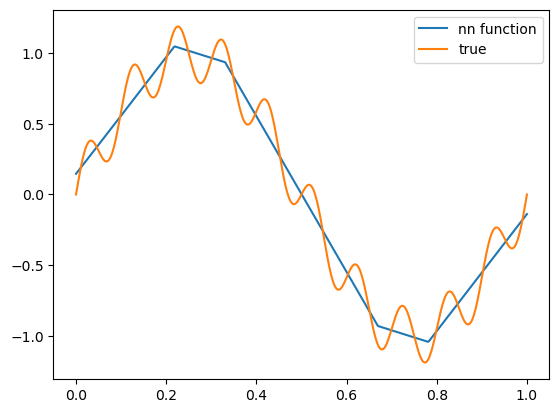

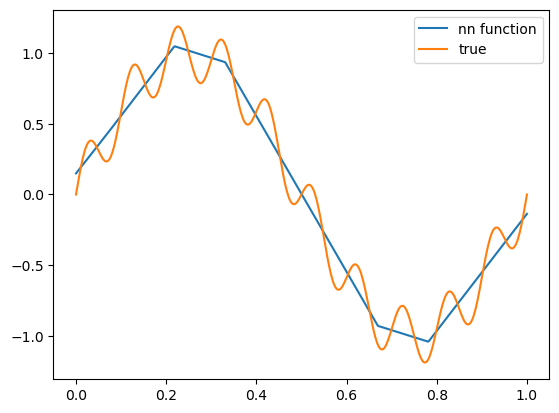

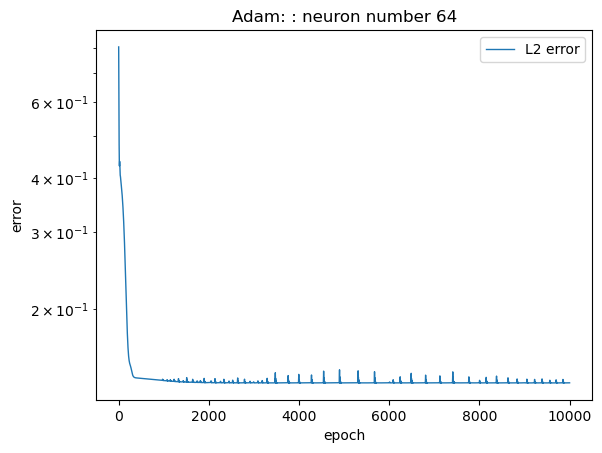

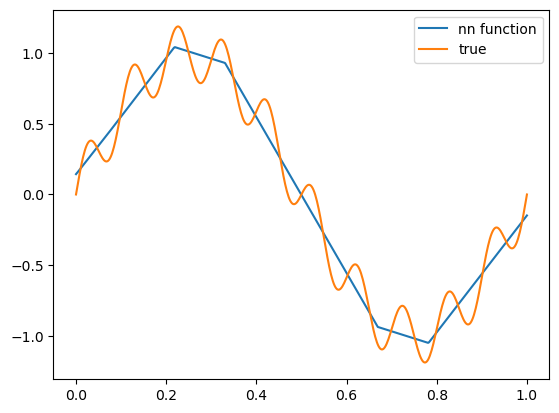

30.134231090545654 s
[tensor([0.3871]), tensor([0.1470]), tensor([0.1470]), tensor([0.1347])]


In [12]:
def target(x):
    return torch.sin(2*pi*x) + 0.2*torch.sin(10*2*pi*x)
err_list = []
for neuron_num in [8,16,32,64]: 
    my_model = model(1,neuron_num,1)
    learning_rate = 0.01 
    Nx = 512 
    order = 2 
    initialize_ = None 
    num_epochs = 10000
    err, my_model = AdamOrGD_train(my_model, target,learning_rate,num_epochs,Nx,order,initialize_)
    err_list.append(min(err))
print(err_list)